In [1]:
import os
import sys
import pathlib
import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import repeat, rearrange
from skimage.transform import resize as nd_resize
from pprint import pprint

# NOTE: ensure you download the artifact folder from the Google Drive link
#   Instructions at: 
#     https://github.com/charzharr/miccai23-swipe-implicit-segmentation

# Set path to .pth checkpoint file
curr_path = pathlib.Path().absolute()
artifacts_path = curr_path / 'experiments' / 'swipe' / 'artifacts' 
assert artifacts_path.is_dir()
pth_path = artifacts_path / 'swipe_run' / 'swipe_last-epoch.pth' 
assert pth_path.is_file()

print(f'💾 Loading pth file from:\n{pth_path}\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
checkpoint = torch.load(pth_path, map_location=device)

print(f'🔑 Checkpoint keys:')
pprint(checkpoint.keys())

cp_config = checkpoint['config']            # config of experiment
cp_state_dict = checkpoint['state_dict']    # nn.Module state_dict
cp_tracker = checkpoint['tracker']          # statistics tracker 

💾 Loading pth file from:
/afs/crc.nd.edu/user/y/yzhang46/miccai23-swipe-implicit-segmentation/src/experiments/swipe/artifacts/swipe_run/swipe_last-epoch.pth

🔑 Checkpoint keys:
dict_keys(['state_dict', 'code_dict', 'tracker', 'config', 'epoch'])


### Get Model and Load Params

In [2]:
## Get Model
from experiments.swipe.model_setup import get_model

swipe_model = get_model(cp_config)
print(swipe_model.load_state_dict(cp_state_dict))

* Norm: (NormFactory2d) - BatchNorm2d
* Act: (ActFactory) - ReLU
	🧠  Block: <class 'experiments.swipe.models.ours.v2.backbone2d.Bottle2neck'>
🪝 Registered in output of Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
🪝 Registered in output of Conv2d(104, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
🪝 Registered in output of Conv2d(128, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
🪝 Registered in output of Conv2d(156, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
🪝 Registered in output of Conv2d(208, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
💠 ReweighAccumulator3 (4,404 params)
      patch_emb_dim: 256
      hidden_dim: 64
      use_rfb: True
💠 ShapeMapperV32d (1,264,436 params)
      stage_dims: [64, 80, 96, 128]
      block_expansion: 2
      hidden_channels: 64
      patch_emb_channels: 256
      use_rfb: True
      accumulator_name: weigh3
      use_rfb_lite: True
💠 ResNet2d (2,169,198 params)
      in_channels: 3
      out_

### Run Inference on 2D Sessile Polyp Segmentation 

In [3]:
## Get Sessile Data
from experiments.swipe import data_setup
data_d = data_setup.get_data_components(cp_config)

data_d = data_d         
df = data_d['df']
train_df = data_d['train_df']
train_set = data_d['train_set']
train_loader = data_d['train_loader']
val_df = data_d['val_df']
val_set = data_d['val_set']
test_df = data_d['test_df']
test_set = data_d['test_set']

Loading df from given path: /afs/crc.nd.edu/user/y/yzhang46/miccai23-swipe-implicit-segmentation/src/experiments/swipe/data/polyp_sessile/splits/118tr-39val-39ts_fs100.csv
correct_df_directories(): No adjustments needed.

Train Data Components:
(Dataset, dim=2) 
  DF_len=118 
  is_train=True 
  Transforms=Compose([
  RandomResizedCrop(always_apply=False, p=1.0, height=384, width=384, scale=[0.2, 0.9], ratio=[0.9, 1.1], interpolation=1),
  HorizontalFlip(always_apply=False, p=0.5),
  VerticalFlip(always_apply=False, p=0.5),
  Rotate(always_apply=False, p=0.5, limit=(-30, 30), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False),
  ColorJitter(always_apply=False, p=0.5, brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.8, 1.2], hue=[-0.2, 0.2]),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params={'format': 'yx', 'label_fields': None, 'remove_invisible': True, 'angle_in_d

In [19]:
## Define light-weight "Trainer" used only for inference
from lib.utils import devices, timers, statistics
from lib.metrics.seg_metrics import batch_metrics
from data.transforms2d.crops.inference import ChopBatchAggregate2d as CBA

class Trainer:
    def __init__(self, config, model, device):
        self.config = config
        self.device = device
        self.task_config = config.task
        
        self.model = model
        self.point_targ_type = self.task_config.points_target
    
    @torch.no_grad()
    def infer(
        self, 
        dataset, 
        epoch,
        queue=None,
        name='test', 
        overlap_perc=0.2,
        save_predictions=False
        ):
        """ Returns metrics for a test or validation set & saves predictions.
        Args:
            num_examples: needed for DDP since rank 0 worker needs a total count
                of examples so it knows how many times to pull metrics from Q.
        """
        # save_predictions = True
        print(f' *Save Predictions: {save_predictions}')
        config = self.config
        lthresh = config.test.logits_thresh
        device = config.experiment.device
        cba_device = 'cuda' if torch.cuda.is_available() else 'cpu'

        watch.tic(name.title())
        epmeter = statistics.EpochMeters()
        self.model.eval()

        watch.tic(f'{name}_iter')
        metric_results = []
        tracked_metrics, k = [], 'dice_summary'
        N_test_samples = 2 if config.experiment.debug.break_test_iter \
                        else len(dataset) 
        for i in range(N_test_samples):
            example_d = dataset[i]
            image = example_d['images']
            mask = example_d['masks_1h']  #  image: float32, mask: uint8

            # Create Chop-Batch-Aggregate inference helper
            test_batch_size = config.test.batch_size
            num_classes = len(dataset.classnames)
            patch_size = config.data[config.data.name].net_in_size
            overlap = [int(overlap_perc * s) for s in patch_size]
            # overlap = [-1, -1]
            cba = CBA(image, patch_size, overlap, 
                      test_batch_size, 1, device=cba_device)
            glob_cba = CBA(image, patch_size, overlap, 
                           test_batch_size, 1, device=cba_device)
            
            size_mult = torch.tensor(patch_size, device=device)[None, None] - 1
                        
            # Get Patch Predictions and Update Aggregator
            for bidx, batch in enumerate(cba):
                crops, locations = batch
                                
                crops = crops.to(device)
                if sum(overlap) < 0:
                    crops = F.interpolate(crops, size=(384, 384))
                
                ## ⭐ Infer
                # Neighboring points to sample which logits are averaged over
                extensions = [(0, 0), 
                              (1, 0), 
                              (0, 1),
                              (-1, 0), 
                              (0, -1),
                              (1, 1), 
                              (-1, -1),
                              (1, -1), 
                              (-1, 1)
                             ]
                # extensions = []

                # out_d = self.model(crops)
                # out_d = infer(crops, model, resolution_stages=(4, 1),
                #              extensions=extensions)
                out_d = self.model.infer_mise(crops, 
                                              resolution_stages=(4, 1),
                                              extensions=extensions)                
                # out_d = self.model.infer(crops, extensions=extensions)
                
                ## Convert local point outputs to image
                logits = out_d['out'] - 0.5
                points = out_d['gp_yx']
                if logits.ndim != 4:
                    # points = out_d['gp'].flip(dims=(-1,))  # xy to yx
                    
                    C = logits.shape[1] 
                    assert C == 1, f'Not supported, {logits.shape}'
                    shape = crops.shape
                    pred_image = torch.zeros((shape[0], C, shape[-2], shape[-1]),
                                             device=crops.device)
                    for b in range(pred_image.shape[0]):
                        b_logits = logits[b]             # 1 x #pts
                        # b_coords = ((points[b] + 1) / 2) # 1 x #pts x 2
                        # b_coords = torch.round(b_coords * size_mult).long()
                        b_coords = points[b]
                        
                        pred_image[b,0,b_coords[:,0],b_coords[:,1]] = b_logits[0]
                else:
                    pred_image = logits
                
                if sum(overlap) < 0:
                    pred_image = F.interpolate(pred_image, size=(400, 500))
                cba.add_batch_predictions(pred_image, locations, 
                                          act=config.test.pred_agg_activation)
                
                # Convert global outputs to image
                glogits = out_d['out_global'] if 'out_global' in out_d else None 
                gpred_image = None
                if glogits is not None:     
                    gpred_image = torch.zeros((shape[0], C, shape[-2], shape[-1]),
                                            device=crops.device)
                    for b in range(gpred_image.shape[0]):
                        b_logits = glogits[b]             # 1 x #pts
                        # b_coords = ((points[b] + 1) / 2) # 1 x #pts x 2
                        # b_coords = torch.round(b_coords * size_mult).long()
                        b_coords = points[b]
                        
                        gpred_image[b,0,b_coords[:,0],
                                    b_coords[:,1]] = b_logits[0]
                    if sum(overlap) < 0:
                        gpred_image = F.interpolate(gpred_image, size=(400, 500))
                    glob_cba.add_batch_predictions(gpred_image, locations, 
                            act=config.test.pred_agg_activation)
                

            # Get Aggregated Predictions
            del crops; del logits;
            agg_predictions = cba.aggregate(ret='none', cpu=True, numpy=False,
                                            act='none') 
            if 'occ' in self.point_targ_type:
                agg_predictions = (agg_predictions >= lthresh).to(torch.uint8)
            else:
                agg_predictions = (agg_predictions <= 0).to(torch.uint8)

            # Compute Metrics
            mets = batch_metrics(agg_predictions[None],
                                 mask[-1][None, None],  
                                 naive_avg=naive_avg,
                                 ignore_background=True)
            metric_results.append(mets)
            tracked_metrics.append(mets[k])
            
            # Save Predictions in Artifacts Folder (?)
            num_epochs = config.train.epochs
            
            if save_predictions:
                pred_arr = agg_predictions[-1]
                mask_arr = mask[-1]
                
                gpred_arr, gtitle = None, ''
                if glogits is not None:
                    if 'occ' in self.point_targ_type:
                        gpred_arr = (glob_cba.aggregate(ret='none', cpu=True, 
                                     numpy=False, act='none') >= lthresh).to(torch.uint8)
                    else:
                        gpred_arr = (glob_cba.aggregate(ret='none', cpu=True, 
                                     numpy=False, act='none') <= 0).to(torch.uint8)
                        
                    gmets = batch_metrics(gpred_arr[None], 
                                          mask[-1][None, None], 
                                          naive_avg=naive_avg,
                                          ignore_background=True)
                    gtitle = f'GP (dice: {gmets[k]:.2f})'
                
                save_planar_image_result(image, pred_arr, mask_arr,
                                         glob_arr=gpred_arr,
                                         pred_title=f'Local Patch Decoding (dice: {mets[k]:.2f})',
                                         glob_title=gtitle)
                
                fp_mask = (pred_arr > 0) & (mask_arr == 0)
                fn_mask = (pred_arr == 0) & (mask_arr > 0)
                                
                # Variance analysis
                if 'logits_var' in out_d:
                    logits_all = out_d['logits_all']
                    logits_mean = out_d['logits_mean']
                    logits_mask = out_d['logits_mask']
                    logits_var = out_d['logits_var']  # B x C x num_pts
                    b = 0
                    c = 0
                    bc_logits_var = logits_var[b, c]
                    # import IPython; IPython.embed(); 
                    
                    shape = out_d['out'].shape
                    C = 1
                    var_image = torch.zeros((shape[0], C, shape[-2], shape[-1]))
                    for b in range(pred_image.shape[0]):
                        b_var = logits_var[b]             # 1 x #pts
                        # b_coords = ((points[b] + 1) / 2) # 1 x #pts x 2
                        # b_coords = torch.round(b_coords * size_mult).long()
                        b_coords = points[b]
                        
                        # Reconstruct variance image from coordinates
                        n_logits = logits_all.shape[-1]
                        vals = logits_all[b, 0].cpu()
                        vals = torch.sign(vals)
                        vals[vals == 0] = 1.0
                        agree = repeat(vals[:, 0], 'n -> n r', r=n_logits - 1) == vals[:, 1:]
                        agree = (~agree).sum(dim=1).float()
                        # var_image[b, 0, b_coords[:,0], b_coords[:,1]] = agree / (n_logits-1)
                        var_image[b, 0, b_coords[:,0], b_coords[:,1]] = agree.clip(0, 1)
                        var_im = torch.from_numpy(nd_resize(var_image[b, 0].numpy(), (400, 500)))
                        
                        # var_image[b,0,b_coords[:,0],b_coords[:,1]] = b_var[0].cpu()
                        
                        # imin, imax = var_image[b,0].min(), var_image[b,0].max()
                        # var_im = (var_image[b, 0] - imin) / (imax - imin + 1e-9)
                       
                        
                        # Plot variance image
                        fig = plt.figure(figsize=(6, 4))
                        ax = fig.add_subplot(1, 2, 1)
                        # im = ax.imshow(nd_resize(var_im, (400, 500)), 
                        #                cmap=plt.cm.get_cmap('RdYlBu'))
                        # print(var_im.unique())
                        ax.set_title(f'Variance Map (from {len(extensions)} Points)')
                        im = ax.imshow(var_im, 
                                       cmap=plt.cm.get_cmap('RdYlBu'))
                        # x, y = np.mgrid[0:384,0:384]
                        # mesh = ax.pcolormesh(x, y , var_image[b, 0].flatten())
                        plt.colorbar(im, ax=ax, fraction=0.03, pad=0.025)
                        
                        ax = fig.add_subplot(1, 2, 2)
                        ax.set_title(f'Prediction Array')
                        im = ax.imshow(pred_arr)
                        plt.axis('off')
                        plt.show()
                        
                        uncert_mask = var_im > 0
                        fp_tmask = (uncert_mask == 1) & (fp_mask == 1)
                        fn_tmask = (uncert_mask == 1) & (fn_mask == 1)
                        print('FP IoU:', (fp_tmask.sum() / fp_mask.sum()).item(),
                              fp_tmask.sum().item(), fp_mask.sum().item())
                        print('FN IoU:', (fn_tmask.sum() / fn_mask.sum()).item(),
                              fn_tmask.sum().item(), fn_mask.sum().item())
                        
                # import IPython; IPython.embed(); 
                # import sys; sys.exit(1)
            
            # Print and Record Metrics
            elaps = watch.toc(f'{name}_iter', disp=False)
            N = len(dataset)
            print(f'🖼️  Inference ({name.title()}) Image {i+1} / {N} '
                f'({elaps:.2f} sec) \n'
                f'       Dice: {float(mets["dice_summary"]):.4f} '
                f' {mets["dice_class"]}',
                flush=True) 
            epmeter.update({k: mets[k] 
                            for k in self.config.serialize.test_metrics})
            
            watch.tic(f'{name}_iter')
            del cba; del agg_predictions

        # Save plot
        if save_predictions:
            fig = plt.figure(figsize=(10, 3))
            ax = fig.add_subplot(2, 1, 1)
            x, y  = list(range(len(dataset))), tracked_metrics
            ax.plot(x, y)
            ax.set_xticks(list(range(0, len(dataset), 2)), minor=True)
            for i, j in zip(x, y):
                ax.annotate(f'{round(j * 100)}', xy=(i-0.05, j+0.1))
            ax.set_ylim(0, 1.0)
            ax = fig.add_subplot(2, 1, 2)
            y  = sorted([[m, i] for i, m in zip(x, tracked_metrics)], 
                        reverse=True)
            ax.plot(x, [v[0] for v in y])
            ax.set_xticks(list(range(0, len(dataset), 2)), minor=True)
            ax.set_ylim(0, 1.0)
            for i, j in zip(x, y):
                ax.annotate(f'{j[1]}', xy=(i, j[0]))
            plt.show()
            plt.close()
                
        # Compute Set-wise Metrics
        final_mets_d = epmeter.avg(no_avg=['tps', 'fps', 'fns'])
        tp, fp, fn = (final_mets_d[k] for k in ['tps', 'fps', 'fns'])
        final_mets_d['dice_summary_agg'] = (2 * tp) / (2 * tp + fp + fn + 1e-7)
        final_mets_d['jaccard_summary_agg'] = tp / (tp + fp + fn + 1e-7)
        
        print(f'FPs: {fp:,}, FNs: {fn:,}')
        
        watch.toc(name.title(), disp=True)
        return final_mets_d, tracked_metrics, metric_results


def save_planar_image_result(image, pred_prob, targ,
                             dpi=120, glob_arr=None, 
                             pred_title='', glob_title=''):
    
    def process_input(image):
        if isinstance(image, torch.Tensor):
            image = image.detach().cpu().numpy()
        
        # Conver to numpy array with canonical image shapes
        if image.ndim == 3:
            if image.shape[0] in (1, 3):
                if image.shape[0] == 1:
                    image = image[0]
                else:
                    assert image.shape[0] == 3, f'Invalid shape {image.shape}'
                    image = np.moveaxis(image, 0, -1)
            else:
                assert image.shape[-1] in (1, 3), f'Invalid shape {image.shape}'
                if image.shape[-1] == 1:
                    image = image[..., 0]
        else:
            assert image.ndim == 2
            
        # Intensity Processing (image is now HxW or HxWx3)
        image = image.astype('float32')
        
        imin, imax = image.min(), image.max()
        imin = 0. if imin == imax else imin
        if imin != 0:
            image -= imin 
        if imax - imin != 1:
            if imax - imin != 0:
                image /= imax - imin 
        
        image = np.round(image * 255).astype('uint8')
        
        return image 
    
    def add_axis(fig, axis_loc, image, title=''):
        ax = fig.add_subplot(axis_loc)
        cmap = 'gray' if image.ndim == 2 else None
        ax.imshow(image, cmap=cmap, vmin=0, vmax=255)
        ax.set_title(title)
        return ax
    
    image_arr = process_input(image) 
    pred_arr = process_input(pred_prob) 
    targ_arr = process_input(targ)
    
    # Error Image
    err_arr = np.zeros(list(targ_arr.shape) + [3], dtype=np.uint8)
    fp_mask = (pred_arr > 0) & (targ_arr == 0)
    fn_mask = (pred_arr == 0) & (targ_arr > 0) 
    err_arr[(pred_arr > 0) & (targ_arr > 0)] = np.array([0, 255, 0])
    err_arr[fp_mask] = np.array([255, 0, 0])
    err_arr[fn_mask] = np.array([0, 0, 255])  
    
    print(f'FPs: {fp_mask.sum():,}, FNs: {fn_mask.sum():,}')
    
    # Plot All Images
    
    ptitle = 'Prediction' if not pred_title else pred_title
    gtitle = 'Global Prediction' if not glob_title else glob_title
    
    if glob_arr is not None:
        gpred_arr = process_input(glob_arr) 
        fig = plt.figure(figsize=(12,8))
        ax = add_axis(fig, 151, image_arr, title='Image')
        ax = add_axis(fig, 152, pred_arr, title=ptitle)
        ax = add_axis(fig, 153, targ_arr, title='Ground Truth')
        ax = add_axis(fig, 154, gpred_arr, title=gtitle)
        ax = add_axis(fig, 155, err_arr, title='Errors')
    else:
        fig = plt.figure(figsize=(12,8))
        ax = add_axis(fig, 141, image_arr, title='Image')
        ax = add_axis(fig, 142, pred_arr, title=ptitle)
        ax = add_axis(fig, 143, targ_arr, title='Ground Truth')
        ax = add_axis(fig, 144, err_arr, title='Errors')
    
    plt.show()
    plt.close()

 *Save Predictions: True
FPs: 135, FNs: 84


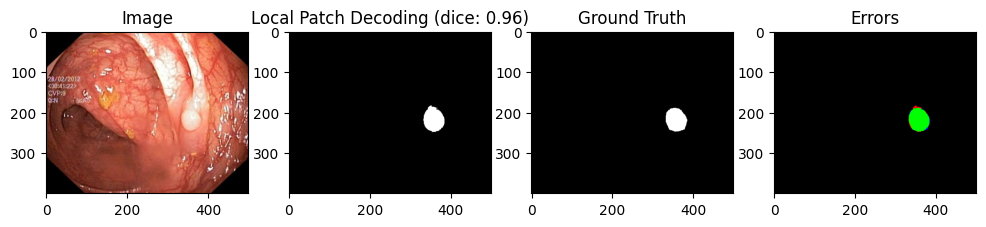

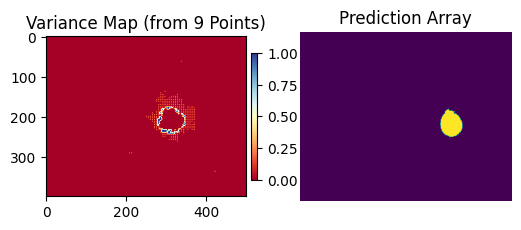

FP IoU: 0.2222222238779068 30 135
FN IoU: 0.0595238097012043 5 84
🖼️  Inference (Test) Image 1 / 39 (0.98 sec) 
       Dice: 0.9553  [0.9553335]
FPs: 186, FNs: 41,578


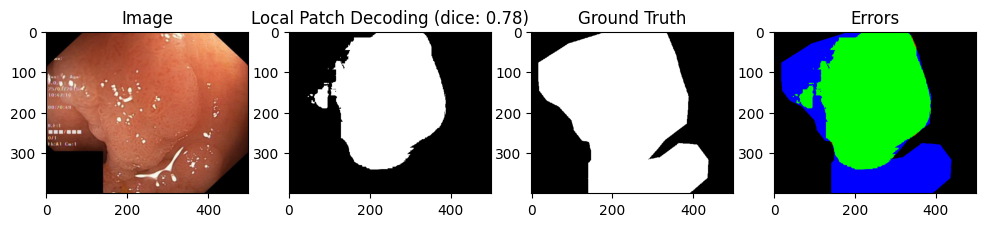

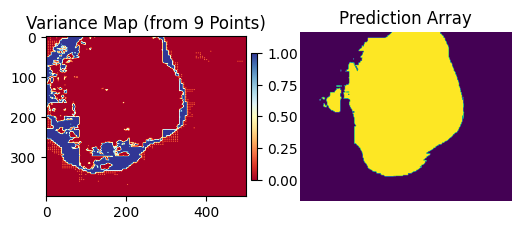

FP IoU: 0.2150537669658661 40 186
FN IoU: 0.047669440507888794 1982 41578
🖼️  Inference (Test) Image 2 / 39 (2.14 sec) 
       Dice: 0.7802  [0.78017557]
FPs: 41, FNs: 4,636


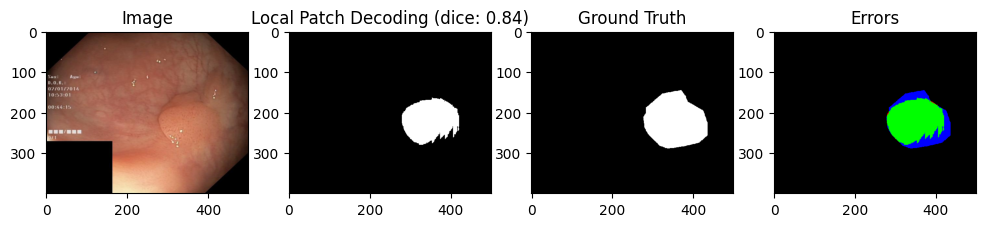

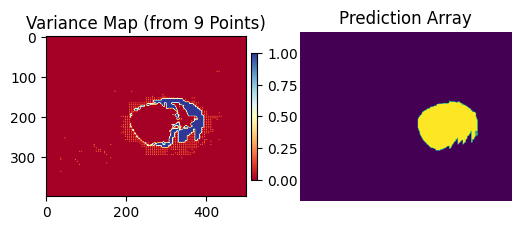

FP IoU: 0.04878048598766327 2 41
FN IoU: 0.2258412390947342 1047 4636
🖼️  Inference (Test) Image 3 / 39 (1.03 sec) 
       Dice: 0.8367  [0.8367254]
FPs: 761, FNs: 492


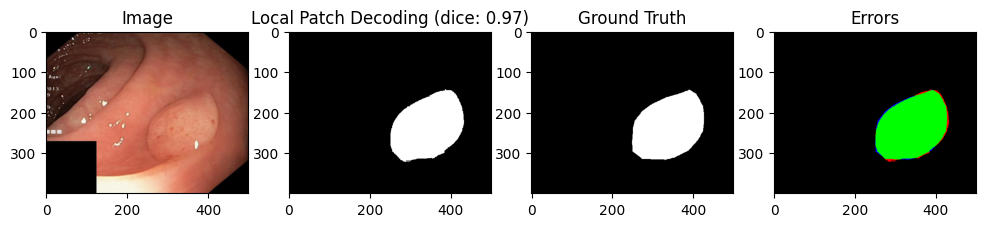

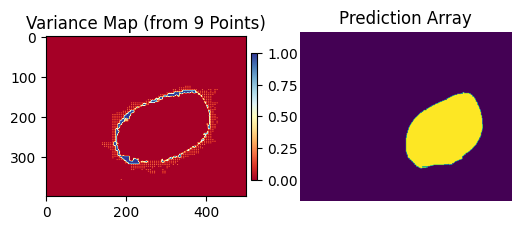

FP IoU: 0.15374507009983063 117 761
FN IoU: 0.018292682245373726 9 492
🖼️  Inference (Test) Image 4 / 39 (1.17 sec) 
       Dice: 0.9728  [0.972817]
FPs: 204, FNs: 946


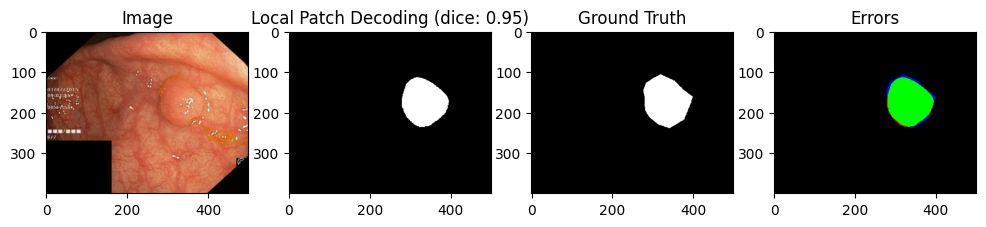

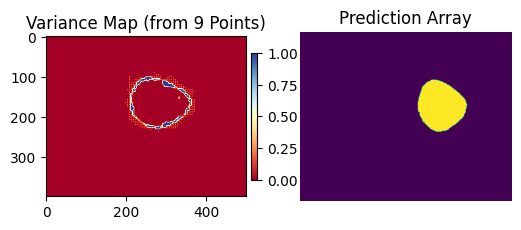

FP IoU: 0.1764705926179886 36 204
FN IoU: 0.09619450569152832 91 946
🖼️  Inference (Test) Image 5 / 39 (1.02 sec) 
       Dice: 0.9463  [0.94634694]
FPs: 9,735, FNs: 57


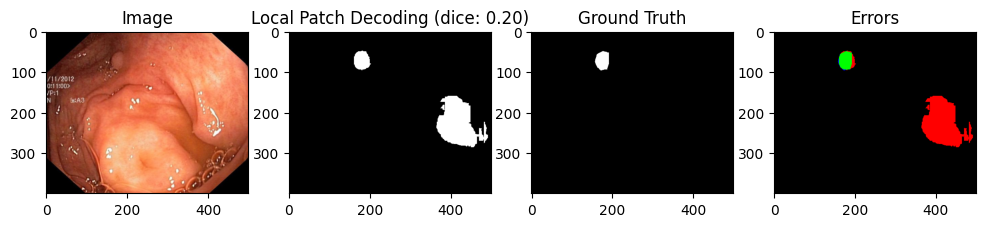

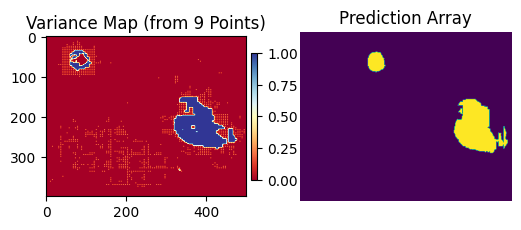

FP IoU: 0.7097072601318359 6909 9735
FN IoU: 0.0 0 57
🖼️  Inference (Test) Image 6 / 39 (1.00 sec) 
       Dice: 0.2035  [0.2035139]
FPs: 190, FNs: 656


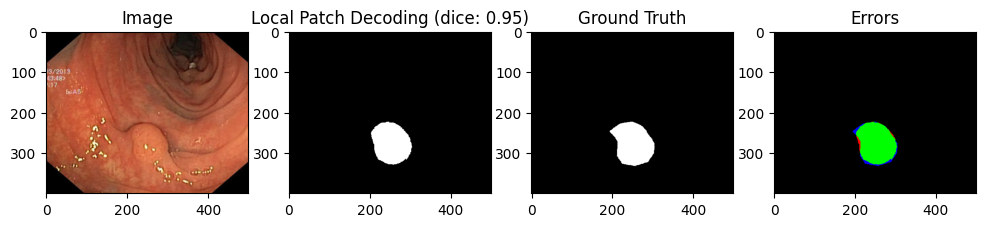

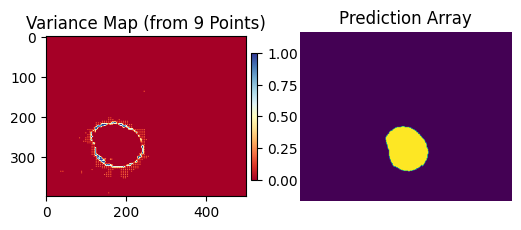

FP IoU: 0.0 0 190
FN IoU: 0.06554877758026123 43 656
🖼️  Inference (Test) Image 7 / 39 (0.99 sec) 
       Dice: 0.9486  [0.9485777]
FPs: 651, FNs: 297


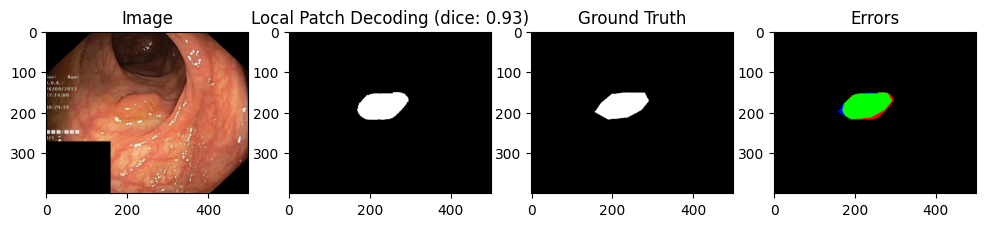

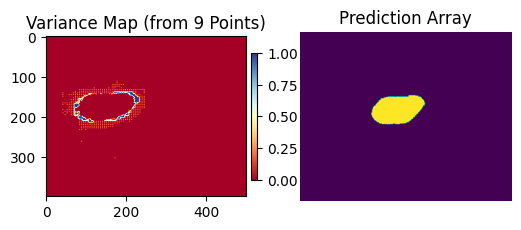

FP IoU: 0.0 0 651
FN IoU: 0.12794612348079681 38 297
🖼️  Inference (Test) Image 8 / 39 (1.20 sec) 
       Dice: 0.9263  [0.92627156]
FPs: 56, FNs: 1,141


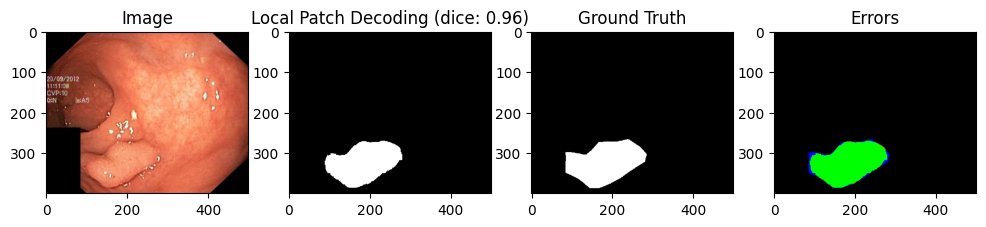

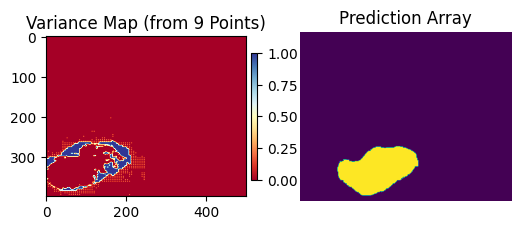

FP IoU: 0.25 14 56
FN IoU: 0.03680981695652008 42 1141
🖼️  Inference (Test) Image 9 / 39 (1.05 sec) 
       Dice: 0.9604  [0.96035767]
FPs: 604, FNs: 1,849


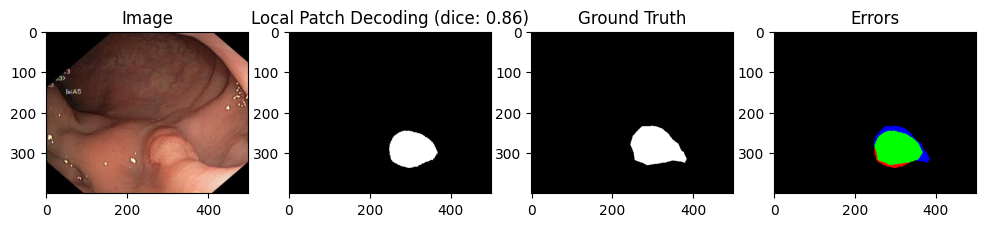

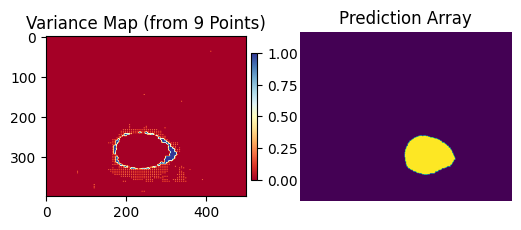

FP IoU: 0.16390728950500488 99 604
FN IoU: 0.05300162360072136 98 1849
🖼️  Inference (Test) Image 10 / 39 (1.00 sec) 
       Dice: 0.8596  [0.85956377]
FPs: 263, FNs: 332


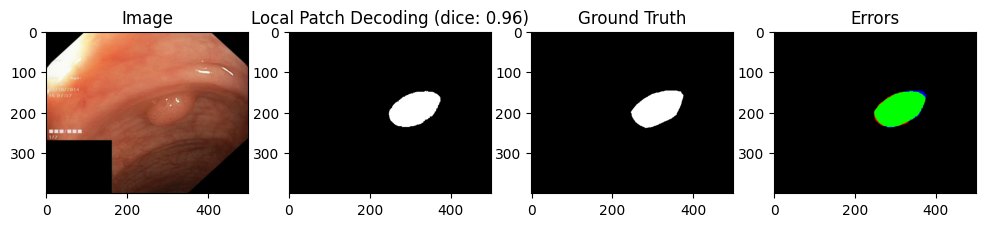

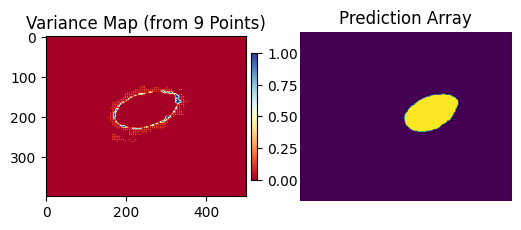

FP IoU: 0.03041825070977211 8 263
FN IoU: 0.07530120760202408 25 332
🖼️  Inference (Test) Image 11 / 39 (0.99 sec) 
       Dice: 0.9629  [0.9629307]
FPs: 8,653, FNs: 3,764


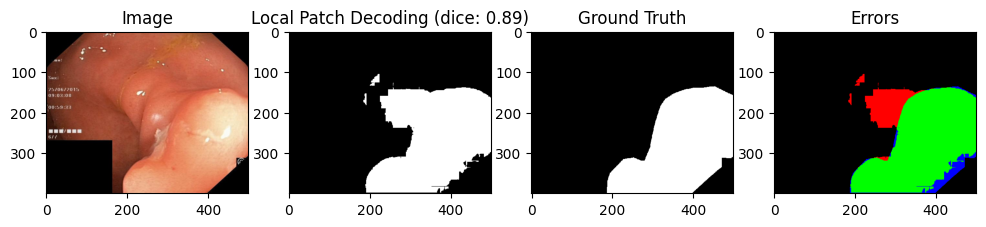

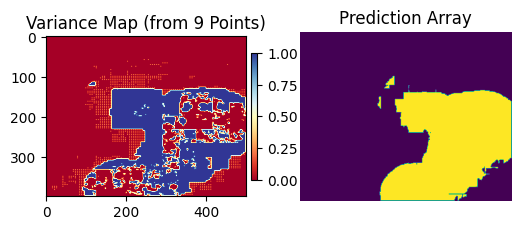

FP IoU: 0.9314688444137573 8060 8653
FN IoU: 0.3326248526573181 1252 3764
🖼️  Inference (Test) Image 12 / 39 (1.52 sec) 
       Dice: 0.8883  [0.88831323]
FPs: 186, FNs: 25


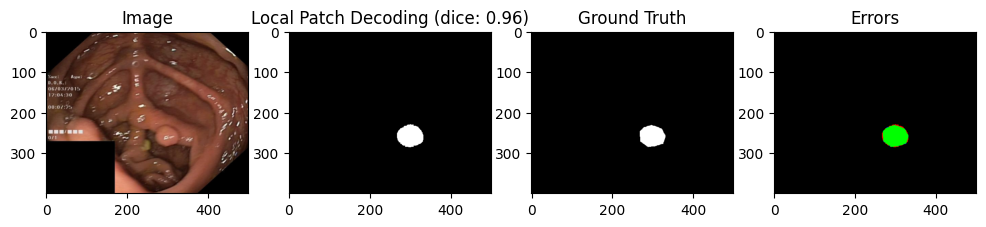

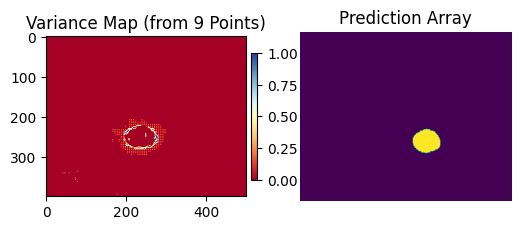

FP IoU: 0.032258063554763794 6 186
FN IoU: 0.1599999964237213 4 25
🖼️  Inference (Test) Image 13 / 39 (1.19 sec) 
       Dice: 0.9614  [0.96136236]
FPs: 420, FNs: 96


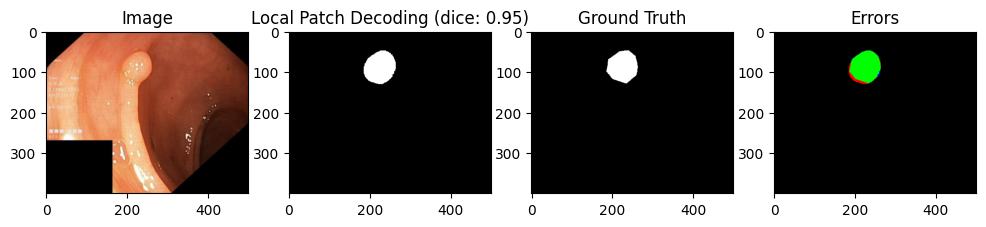

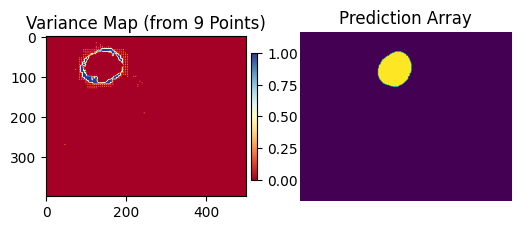

FP IoU: 0.05000000074505806 21 420
FN IoU: 0.02083333395421505 2 96
🖼️  Inference (Test) Image 14 / 39 (0.97 sec) 
       Dice: 0.9468  [0.94682604]
FPs: 1,732, FNs: 13


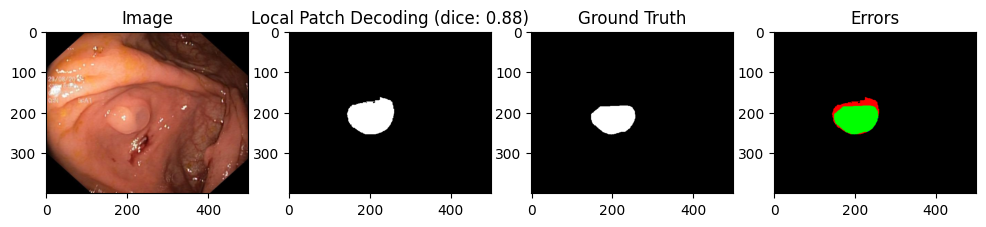

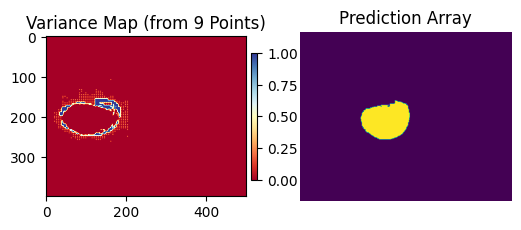

FP IoU: 0.1593533456325531 276 1732
FN IoU: 0.0 0 13
🖼️  Inference (Test) Image 15 / 39 (0.99 sec) 
       Dice: 0.8754  [0.87536603]
FPs: 1,949, FNs: 45


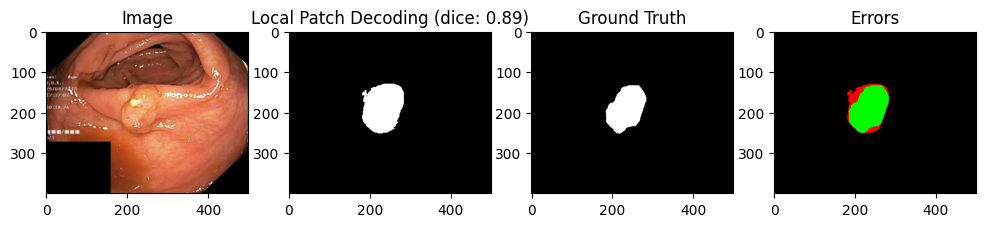

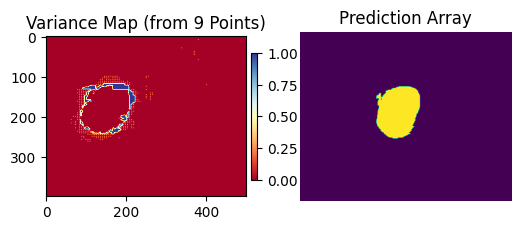

FP IoU: 0.1334017515182495 260 1949
FN IoU: 0.0 0 45
🖼️  Inference (Test) Image 16 / 39 (1.01 sec) 
       Dice: 0.8905  [0.89046365]
FPs: 324, FNs: 89


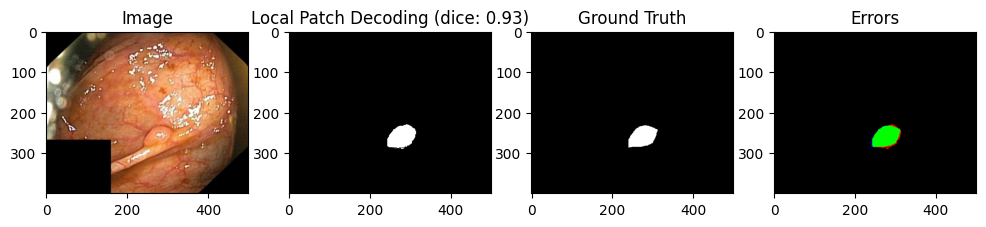

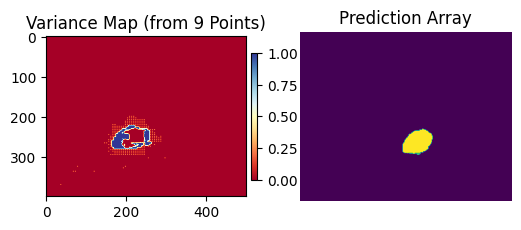

FP IoU: 0.003086419776082039 1 324
FN IoU: 0.5955055952072144 53 89
🖼️  Inference (Test) Image 17 / 39 (0.96 sec) 
       Dice: 0.9304  [0.93038934]
FPs: 1,594, FNs: 18


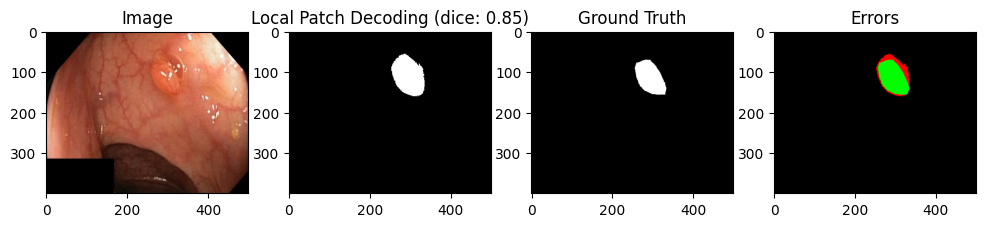

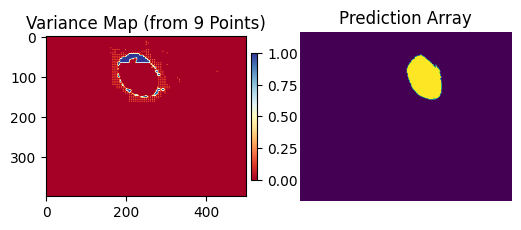

FP IoU: 0.07716436684131622 123 1594
FN IoU: 0.0 0 18
🖼️  Inference (Test) Image 18 / 39 (0.97 sec) 
       Dice: 0.8514  [0.85140115]
FPs: 364, FNs: 6,586


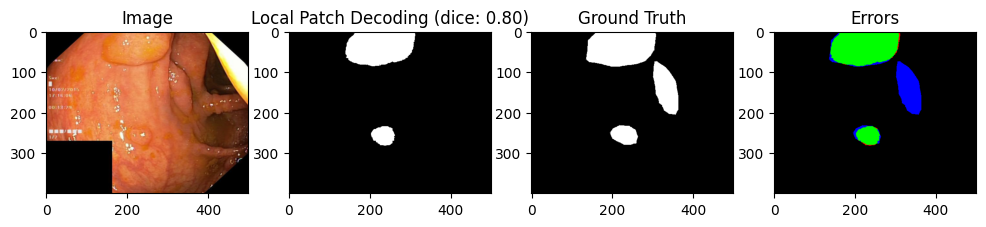

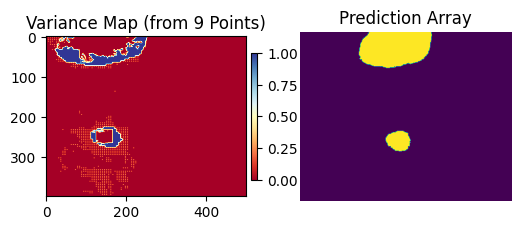

FP IoU: 0.11538461595773697 42 364
FN IoU: 0.029456423595547676 194 6586
🖼️  Inference (Test) Image 19 / 39 (1.29 sec) 
       Dice: 0.8045  [0.8045337]
FPs: 92, FNs: 707


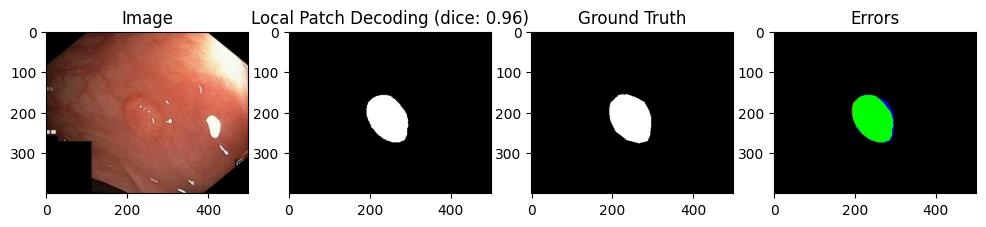

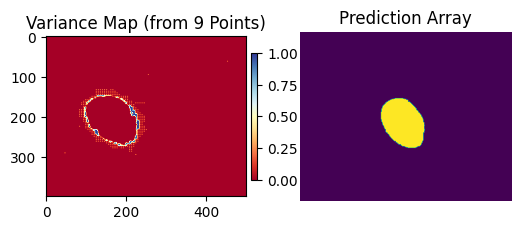

FP IoU: 0.021739130839705467 2 92
FN IoU: 0.005657708737999201 4 707
🖼️  Inference (Test) Image 20 / 39 (1.01 sec) 
       Dice: 0.9573  [0.9572933]
FPs: 297, FNs: 220


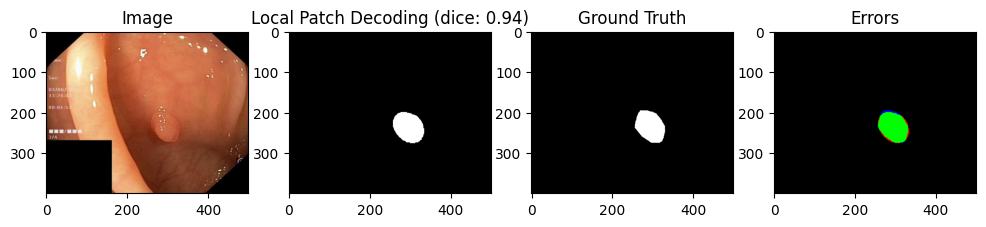

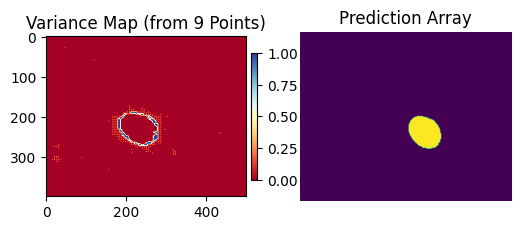

FP IoU: 0.09090909361839294 27 297
FN IoU: 0.1772727221250534 39 220
🖼️  Inference (Test) Image 21 / 39 (0.96 sec) 
       Dice: 0.9425  [0.94251084]
FPs: 2,043, FNs: 0


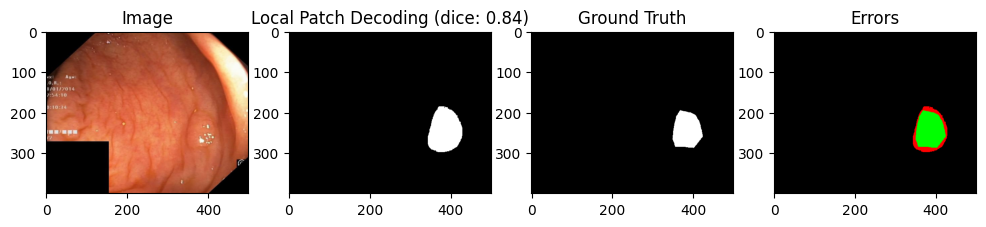

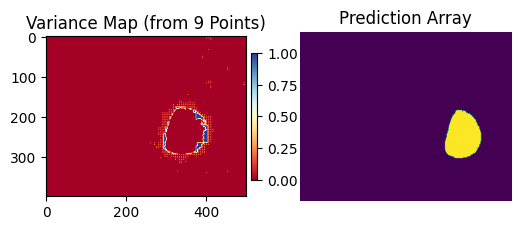

FP IoU: 0.17963778972625732 367 2043
FN IoU: nan 0 0
🖼️  Inference (Test) Image 22 / 39 (0.97 sec) 
       Dice: 0.8388  [0.83879113]
FPs: 4,031, FNs: 1,505


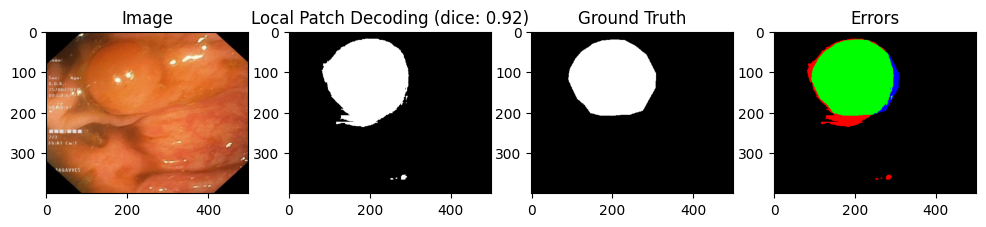

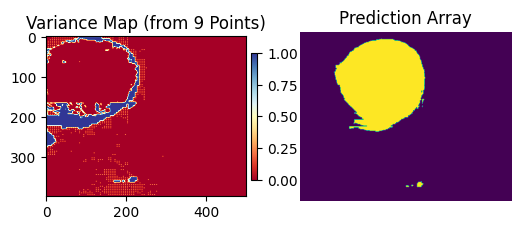

FP IoU: 0.12751178443431854 514 4031
FN IoU: 0.0 0 1505
🖼️  Inference (Test) Image 23 / 39 (1.34 sec) 
       Dice: 0.9163  [0.91634685]
FPs: 212, FNs: 1,674


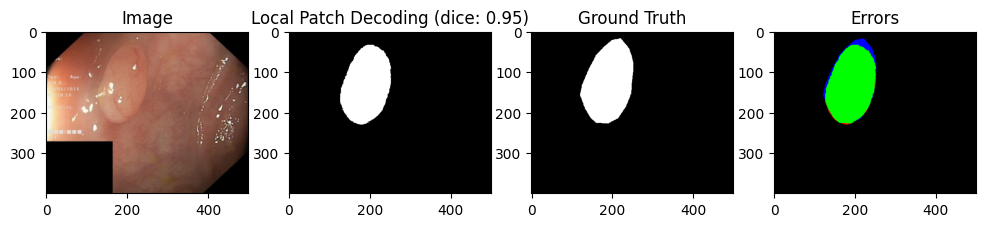

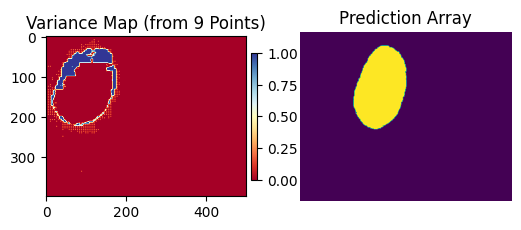

FP IoU: 0.06603773683309555 14 212
FN IoU: 0.03285543620586395 55 1674
🖼️  Inference (Test) Image 24 / 39 (1.12 sec) 
       Dice: 0.9501  [0.95014805]
FPs: 96, FNs: 451


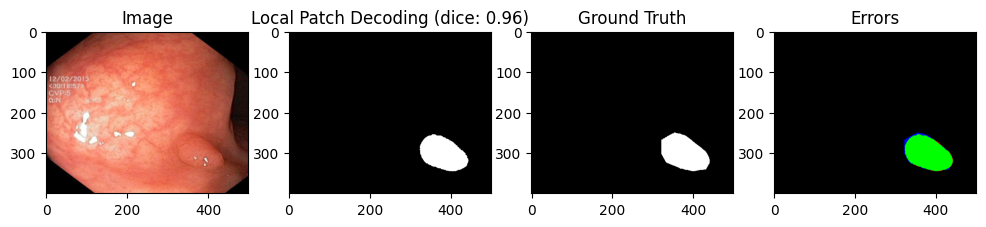

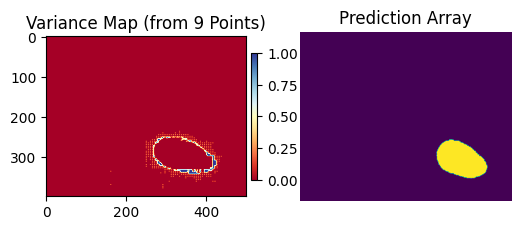

FP IoU: 0.1354166716337204 13 96
FN IoU: 0.19290465116500854 87 451
🖼️  Inference (Test) Image 25 / 39 (1.21 sec) 
       Dice: 0.9649  [0.96485704]
FPs: 452, FNs: 562


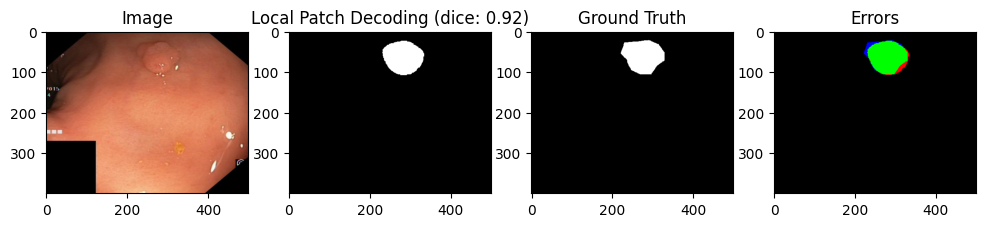

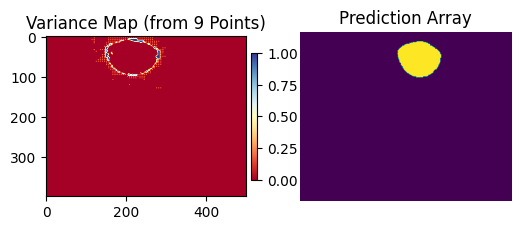

FP IoU: 0.0 0 452
FN IoU: 0.02846975065767765 16 562
🖼️  Inference (Test) Image 26 / 39 (0.97 sec) 
       Dice: 0.9234  [0.9234139]
FPs: 3,483, FNs: 1,356


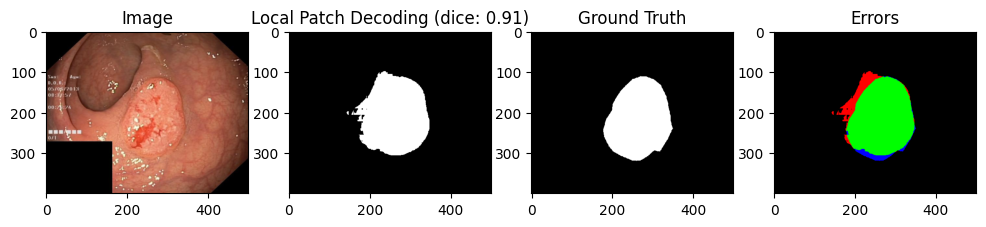

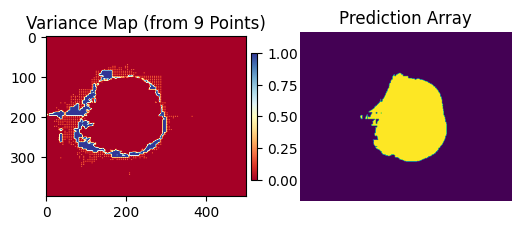

FP IoU: 0.04478897526860237 156 3483
FN IoU: 0.15265487134456635 207 1356
🖼️  Inference (Test) Image 27 / 39 (1.25 sec) 
       Dice: 0.9093  [0.90931237]
FPs: 422, FNs: 529


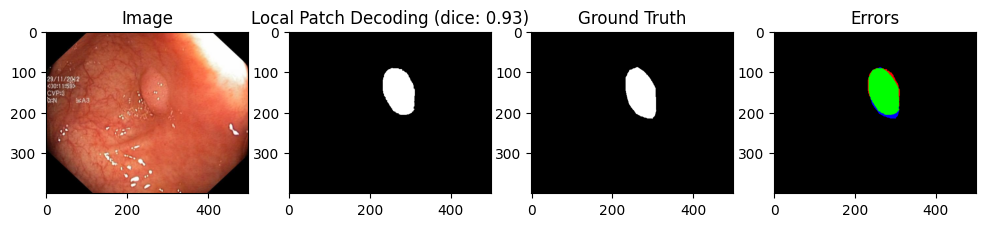

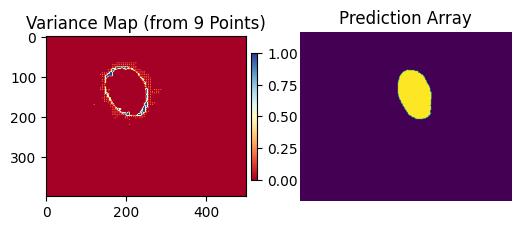

FP IoU: 0.02606634981930256 11 422
FN IoU: 0.10018903762102127 53 529
🖼️  Inference (Test) Image 28 / 39 (0.97 sec) 
       Dice: 0.9340  [0.9340271]
FPs: 914, FNs: 175


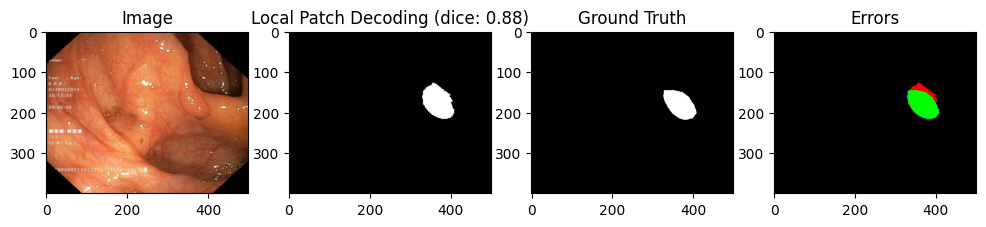

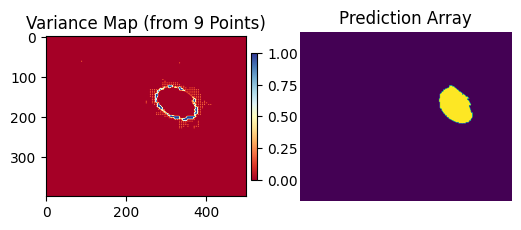

FP IoU: 0.195842444896698 179 914
FN IoU: 0.04571428522467613 8 175
🖼️  Inference (Test) Image 29 / 39 (0.96 sec) 
       Dice: 0.8788  [0.87882495]
FPs: 1,303, FNs: 2,300


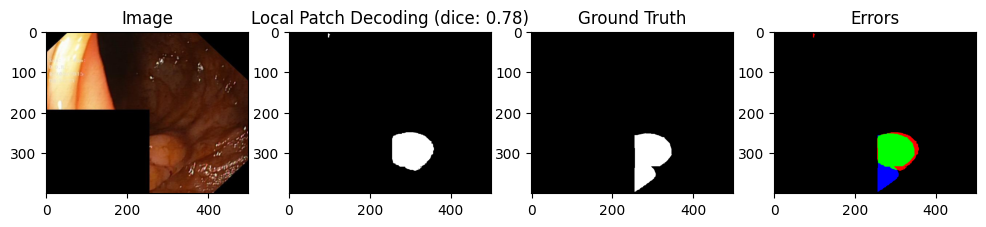

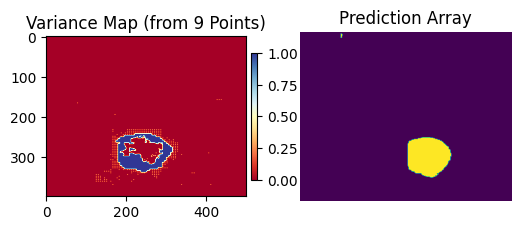

FP IoU: 0.021488871425390244 28 1303
FN IoU: 0.08521739393472672 196 2300
🖼️  Inference (Test) Image 30 / 39 (0.98 sec) 
       Dice: 0.7811  [0.7811456]
FPs: 87, FNs: 1,519


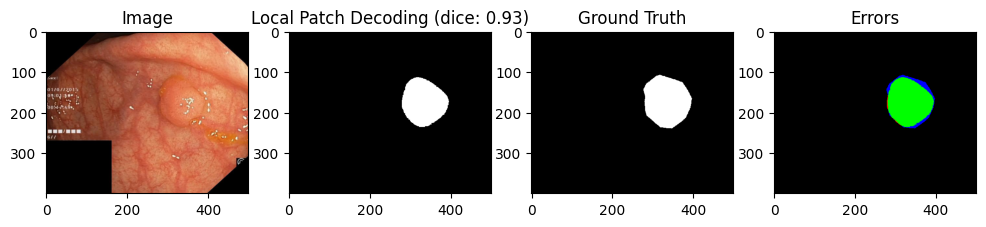

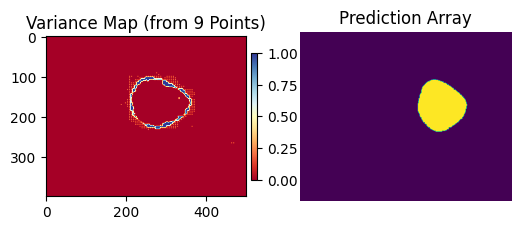

FP IoU: 0.2068965584039688 18 87
FN IoU: 0.05859117954969406 89 1519
🖼️  Inference (Test) Image 31 / 39 (1.25 sec) 
       Dice: 0.9273  [0.9272777]
FPs: 534, FNs: 1,612


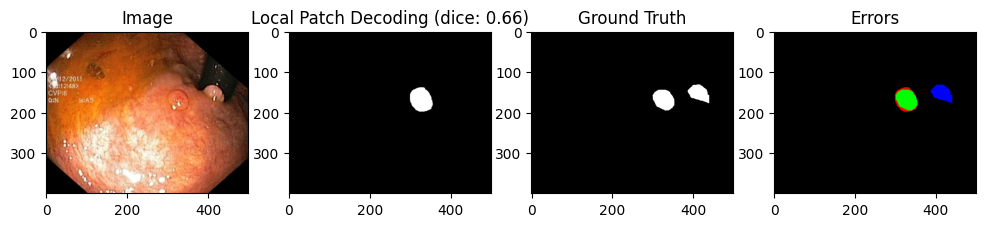

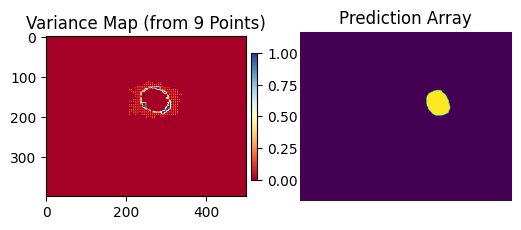

FP IoU: 0.2584269642829895 138 534
FN IoU: 0.0 0 1612
🖼️  Inference (Test) Image 32 / 39 (0.96 sec) 
       Dice: 0.6604  [0.66044307]
FPs: 876, FNs: 19


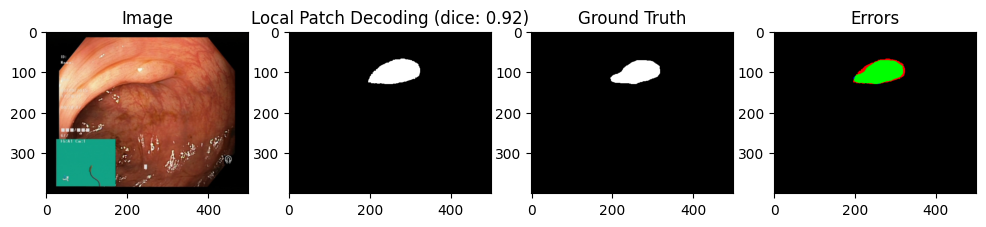

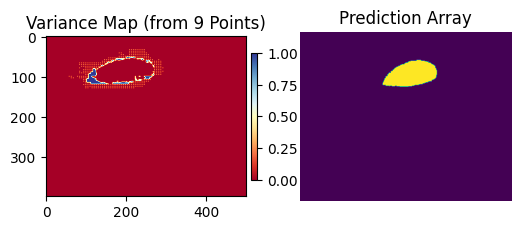

FP IoU: 0.04680365324020386 41 876
FN IoU: 0.5789473652839661 11 19
🖼️  Inference (Test) Image 33 / 39 (0.96 sec) 
       Dice: 0.9162  [0.9162377]
FPs: 3,738, FNs: 236


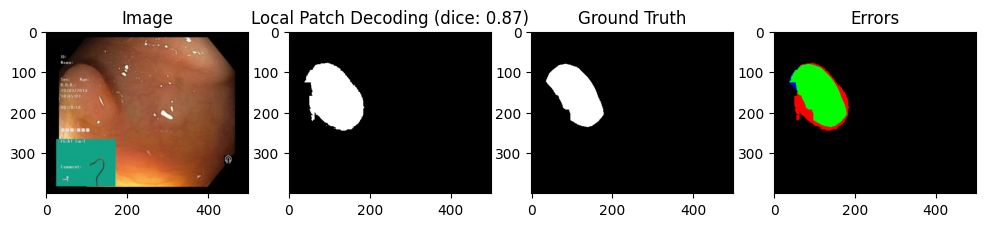

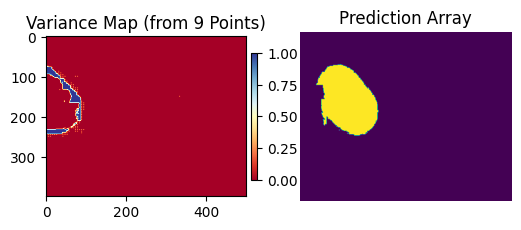

FP IoU: 0.10674156993627548 399 3738
FN IoU: 0.5042372941970825 119 236
🖼️  Inference (Test) Image 34 / 39 (1.04 sec) 
       Dice: 0.8671  [0.8670725]
FPs: 462, FNs: 9


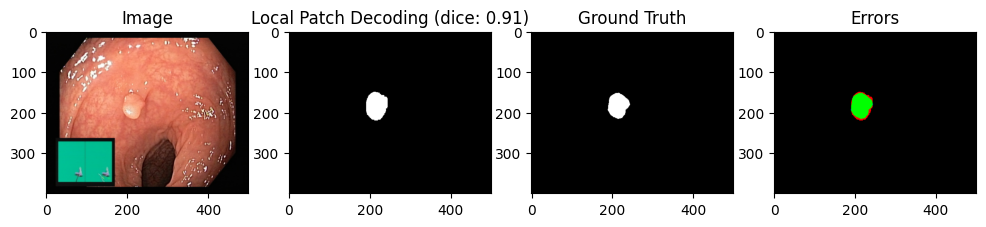

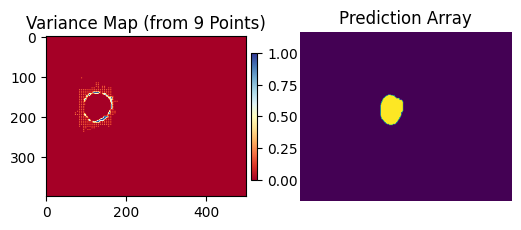

FP IoU: 0.0 0 462
FN IoU: 0.0 0 9
🖼️  Inference (Test) Image 35 / 39 (0.96 sec) 
       Dice: 0.9136  [0.9135938]
FPs: 1,877, FNs: 5,578


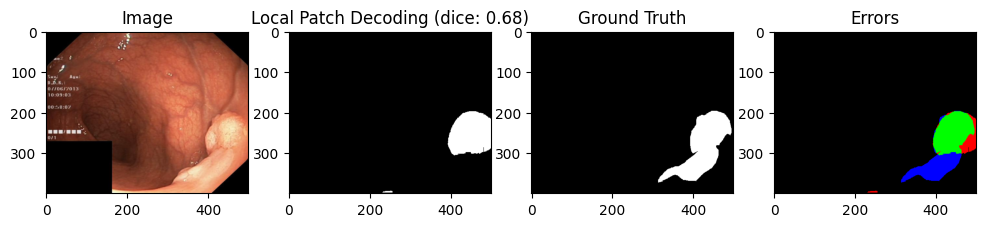

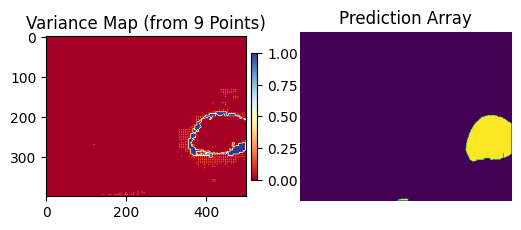

FP IoU: 0.4885455369949341 917 1877
FN IoU: 0.06435998529195786 359 5578
🖼️  Inference (Test) Image 36 / 39 (0.99 sec) 
       Dice: 0.6759  [0.67591184]
FPs: 1,066, FNs: 8,583


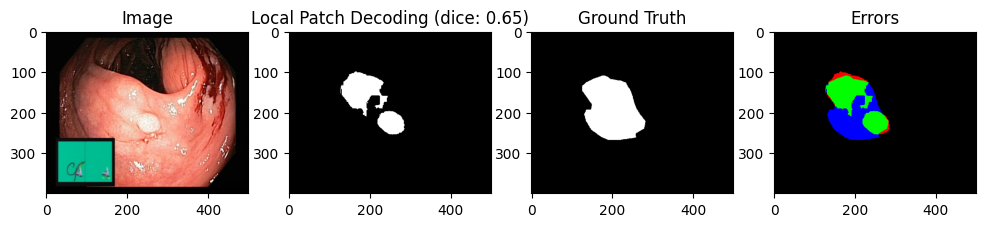

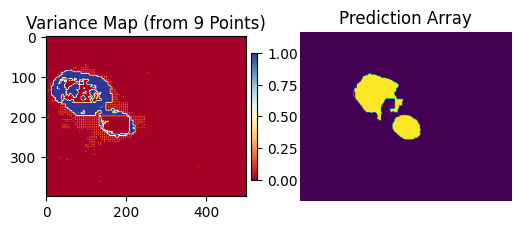

FP IoU: 0.18198874592781067 194 1066
FN IoU: 0.2555050551891327 2193 8583
🖼️  Inference (Test) Image 37 / 39 (1.25 sec) 
       Dice: 0.6477  [0.6476538]
FPs: 218, FNs: 53,007


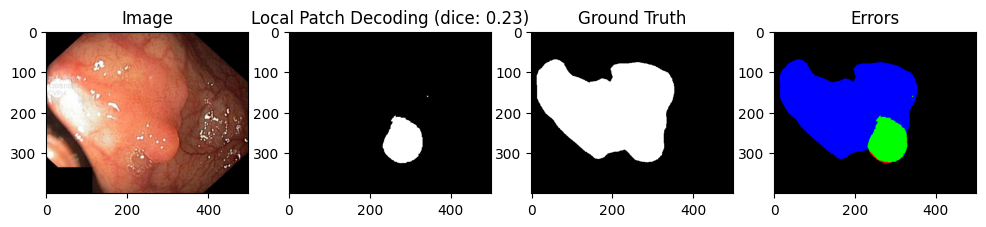

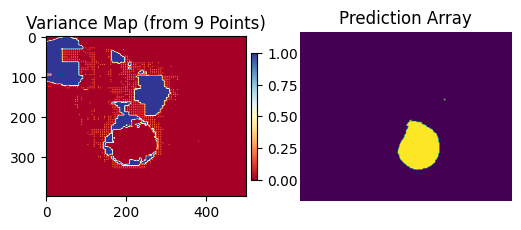

FP IoU: 0.11926605552434921 26 218
FN IoU: 0.3118644654750824 16531 53007
🖼️  Inference (Test) Image 38 / 39 (1.04 sec) 
       Dice: 0.2341  [0.23411757]
FPs: 637, FNs: 323


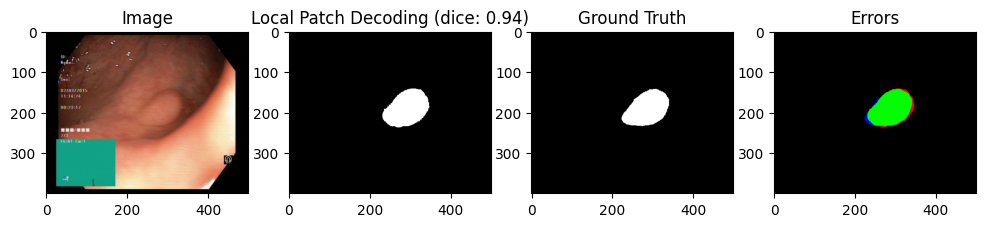

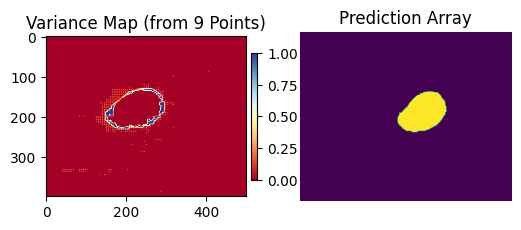

FP IoU: 0.0282574575394392 18 637
FN IoU: 0.21671827137470245 70 323
🖼️  Inference (Test) Image 39 / 39 (0.99 sec) 
       Dice: 0.9371  [0.93713987]


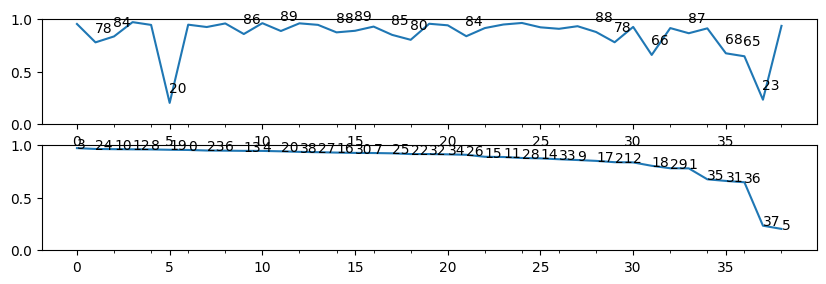

FPs: 50,888, FNs: 143,069
StopWatch(Test) took 43.16 sec
0.8532663981119791 Dice (%): 0.85326642


In [20]:
## Run Inference 
naive_avg = True

watch = timers.StopWatch()
trainer = Trainer(cp_config, swipe_model.to(device), device)
mets_d, dices, met_ds = trainer.infer(test_set, 0, 
                                      name='test', 
                                      overlap_perc=0.75, 
                                      save_predictions=True)
print(mets_d['dice_summary'], f'Dice (%): {np.mean(dices):.8f}')